## Example fitting for a gaussian

Fitting a guassian model to a synthetically generated data as a practice for using emcee and mcmc methods for fitting and estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
# Defining the basis gaussian model

def model(theta, x): 
    mu, sigma = theta
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

# Setting up the true values

mu_true = 5
sigma_true = 3.2

theta_true = [mu_true, sigma_true]

In [3]:
# Generating synthetic data 
x = np.sort(np.random.uniform(-10, 10, 100))    # 100 random points between -10 and 10 that are sorted
y = model(theta_true, x)

y_err = 0.03*np.random.rand(len(x))     # Random error for each point

if np.random.rand() < 0.5:    # Randomly decide whether to add or subtract the error
    y += y_err 
else: 
    y -= y_err

In [4]:
# Defining the log-likelihood function

def lnlike(theta, x, y, y_err):
    return -0.5 * np.sum(((y - model(theta, x)) / y_err) ** 2)

# Defining the log-prior function

def lnprior(theta):
    mu, sigma = theta
    if sigma <= 0 or mu < -10 or mu > 10:
        return -np.inf
    return 0.0

# Defining the log-posterior function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

# Can probably incorporate all the above functions into a single function
# but this is apparently the "conventional" way to do it

In [5]:
# Setting initial values for the parameters
initial = [6.0, 6.0]

# Setting up the MCMC sampler
ndim = len(initial)
nwalkers = 6    # Preferentially 3-5 times the number of dimensions (minimum 2 times the number of dimensions)
n_burn = 200
n_steps = 10000

# Initializing the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, y_err))
p0 = [initial + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]    # Adding little variation to the initial positions

In [6]:
# Running the MCMC sampler

# Burn-in phase
print("Running burn-in phase...")
sampler.reset()
state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

# Main sampling phase
print("Running main sampling phase...")
pos, prob, state = sampler.run_mcmc(state, n_steps, progress=True)

# Extracting the samples
samples = sampler.get_chain(flat=True)      # Flatten the chain to get all samples in a single array


Running burn-in phase...


100%|██████████| 200/200 [00:00<00:00, 807.33it/s]


Running main sampling phase...


100%|██████████| 10000/10000 [00:08<00:00, 1112.86it/s]


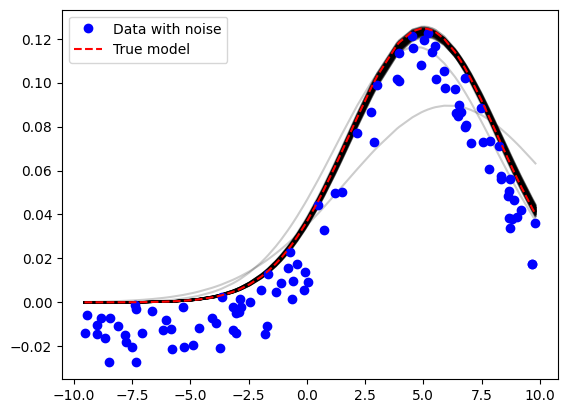

In [7]:
# Plotting the results

for theta in samples[np.random.randint(len(samples), size=100)]:    # Randomly select 100 samples for plotting
    plt.plot(x, model(theta, x), color='k', alpha=0.2)

plt.plot(x, y, 'o', color='blue', label='Data with noise')      # Plot the noisy data
plt.plot(x, model(theta_true, x),'r--', label='True model')    # Plot the true model
plt.legend()
plt.show()

[5.04570961 3.23237828]


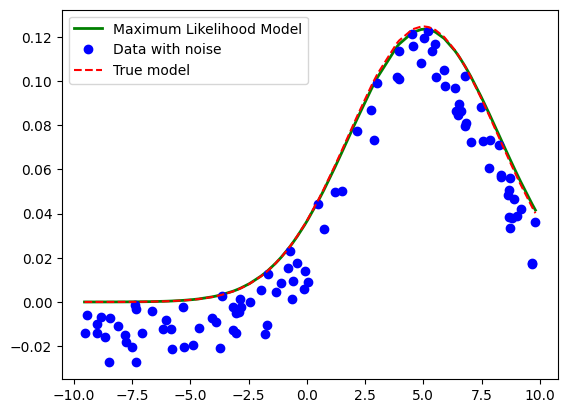

In [8]:
# Obtaining the maximum likelihood estimate

theta_max = samples[np.argmax(sampler.flatlnprobability)]
print(theta_max)

# Plotting the maximum likelihood estimate

plt.plot(x, model(theta_max, x), label='Maximum Likelihood Model', color='green', linewidth=2)
plt.plot(x, y, 'o', color='blue', label='Data with noise')      # Plot the noisy data
plt.plot(x, model(theta_true, x),'r--', label='True model')    # Plot the true model
plt.legend()
plt.show()

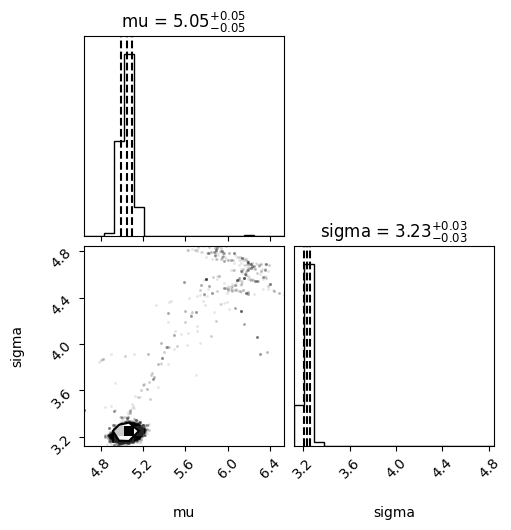

In [9]:
# Plotting a corner plot of the samples along with the quantiles

fig = corner.corner(samples, labels=["mu", "sigma"],  quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_datapoints=True)